In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('daily_consumption.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9264 entries, 0 to 9263
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Site ID                   8316 non-null   object 
 1   Energy Consumption (kWh)  8316 non-null   float64
 2   Date                      9264 non-null   object 
dtypes: float64(1), object(2)
memory usage: 217.3+ KB


In [ ]:
df['Site ID'].unique()

array(['CCC0501', 'CCC0511', 'CCC0543', 'CCC0545', 'CCC0571', 'CCC0611',
       nan, 'CCC1140', 'CCC2044', 'CCC0047', 'CCC4103', 'CCC1026',
       'CCC4101', 'CCC1061', 'CCC2003', 'CCC1186', 'CCC2028', 'CCC2008',
       'CCC1188', 'CCC1059', 'CCC1181', 'CCC1150', 'CCC2009', 'CCC0088',
       'CCC0092'], dtype=object)

> Let us pick 1 site.

In [ ]:
def read_file(data, site):
    """Function: Reads raw kWh report, generates dataframe for one customer site"""

    data['Date'] = pd.to_datetime(data['Date'], format = 'mixed')
    data = data.set_index(data['Date'])
    dff = data.loc[data['Site ID'] == site]

    return site, dff


site, data_daily = read_file(df,'CCC0501')

data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 386 entries, 2019-11-01 to 2020-11-20
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Site ID                   386 non-null    object        
 1   Energy Consumption (kWh)  386 non-null    float64       
 2   Date                      386 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 12.1+ KB


# Data exploration

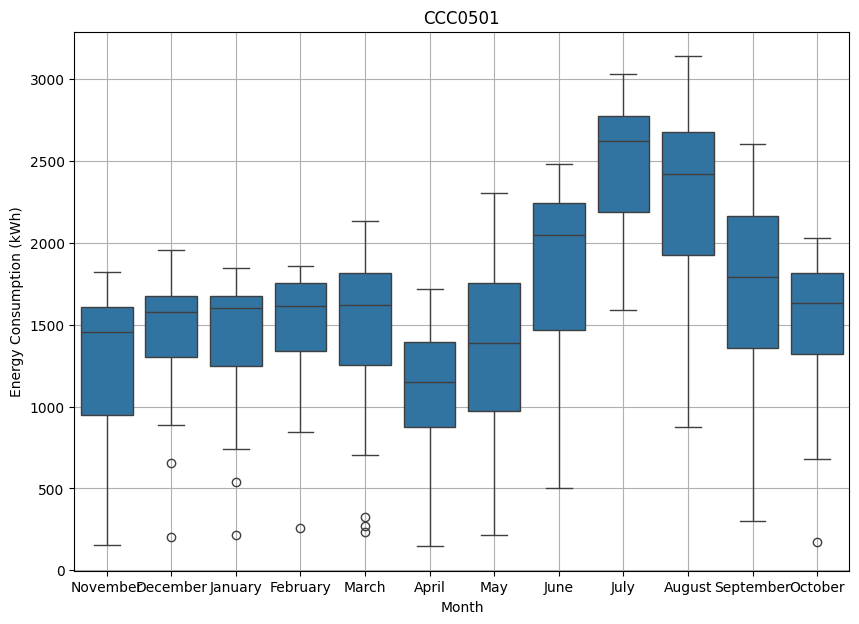

In [ ]:
#Lets check monthly energy consumption over a period of 1 year at the site

data_daily['Month'] = data_daily.index.month_name()
#data_daily['Year'] = data_daily.index.year
#data_daily['Week'] = data_daily.index.week
data_daily['Day'] = data_daily.index.day_name()
plt.figure(figsize = (10, 7))
sns.boxplot(data = data_daily, x = 'Month', y = 'Energy Consumption (kWh)')
plt.ylabel('Energy Consumption (kWh)')
plt.title(site)
plt.xlabel('Month')
plt.grid()

**Consumption is higher from June till October!**

In [ ]:
#n = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
#plt.figure(figsize = (10, 7))
#data_daily['Energy Consumption (kWh)'].groupby(data_daily['Day']).plot()
#plt.ylabel('Energy Consumption (kWh)')
#plt.legend()
#plt.grid()

In [ ]:
n = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
#data_daily['Energy Consumption (kWh)'].groupby(data_daily['Day']).sum().plot()
data_daily['Energy Consumption (kWh)'].groupby(data_daily['Day']).sum().round(2).reindex(n)

,Energy Consumption (kWh)
Day,
Sunday,45856.19
Monday,95264.05
Tuesday,103948.70
Wednesday,103318.30
Thursday,103405.57
Friday,101377.32
Saturday,59752.19


In [ ]:
data_daily['Energy Consumption (kWh)'].groupby(data_daily['Day']).mean().round(2).reindex(n)

,Energy Consumption (kWh)
Day,
Sunday,833.75
Monday,1732.07
Tuesday,1889.98
Wednesday,1878.51
Thursday,1880.10
Friday,1810.31
Saturday,1086.40


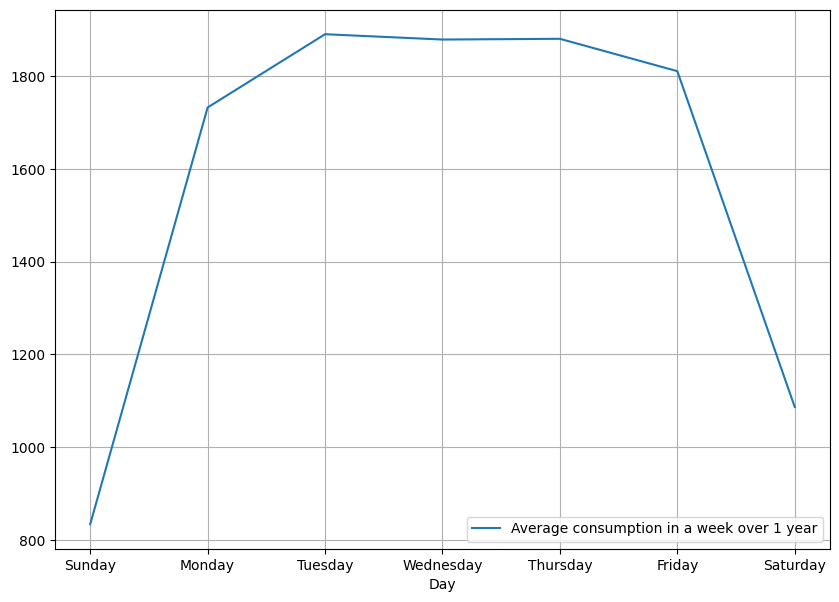

In [ ]:
plt.figure(figsize = (10, 7))
data_daily['Energy Consumption (kWh)'].groupby(data_daily['Day']).mean().reindex(n).plot()
plt.grid()
plt.legend(['Average consumption in a week over 1 year'])

**Except weekends (Sat & Sun), consumption is more or less similar on an average on weekdays !**

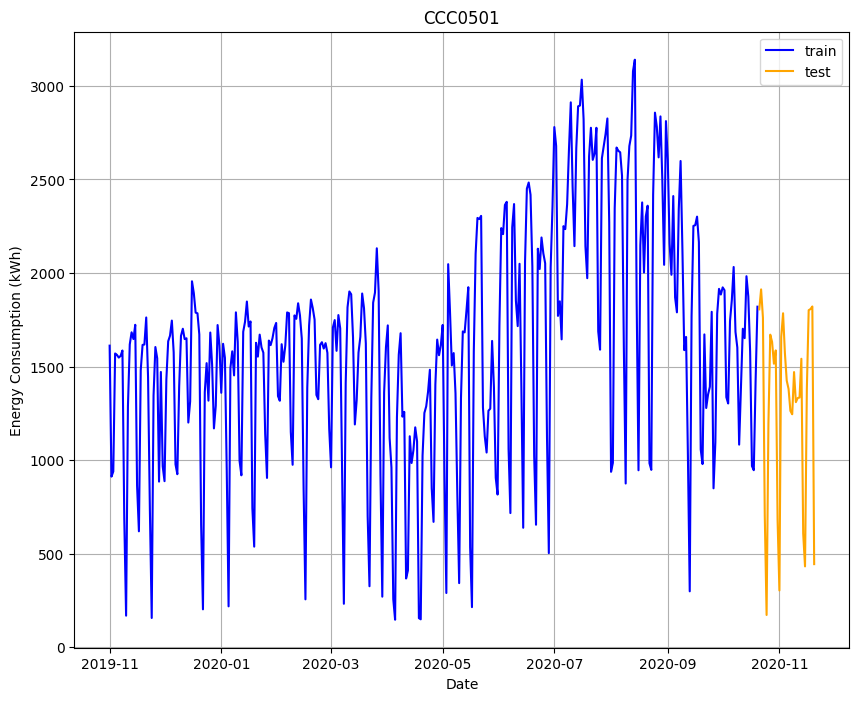

In [ ]:
def split_data(data):
    """Function: Splits time-series data into train & test sets and plots them"""

    min_value, max_value = data['Date'].min(), data['Date'].max()
    train = data['Energy Consumption (kWh)'].loc[min_value:'2020-10-20']
    test = data['Energy Consumption (kWh)'].loc['2020-10-21':max_value]

    plt.figure(figsize = (10, 8))
    plt.plot(train, color = 'b', label = 'train')
    plt.title(site)
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.plot(test, color = 'orange', label = 'test')
    plt.grid()
    plt.legend()
    plt.show()

    return train, test

train, test = split_data(data_daily)

# Seasonal decomposition of time-series into its components

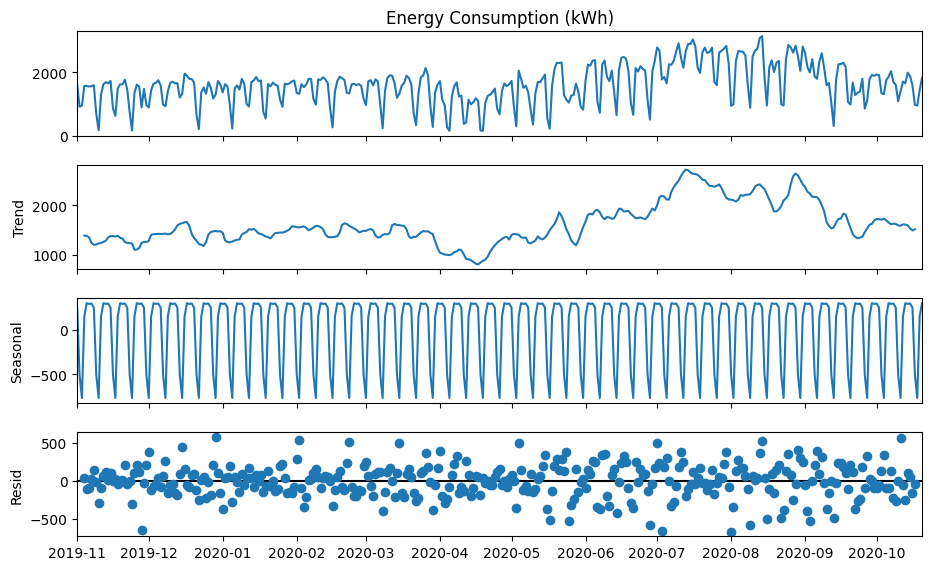

In [ ]:
seasonal_decompose(train, period = 7).plot().set_size_inches(10, 6)              #additive model by default

In [ ]:
#seasonal_decompose(train, period = 7, model = 'multiplicative').plot().set_size_inches(10, 6)

# Fourier transform: Decomposes a time-domain function into the frequency domain

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Amplitude')

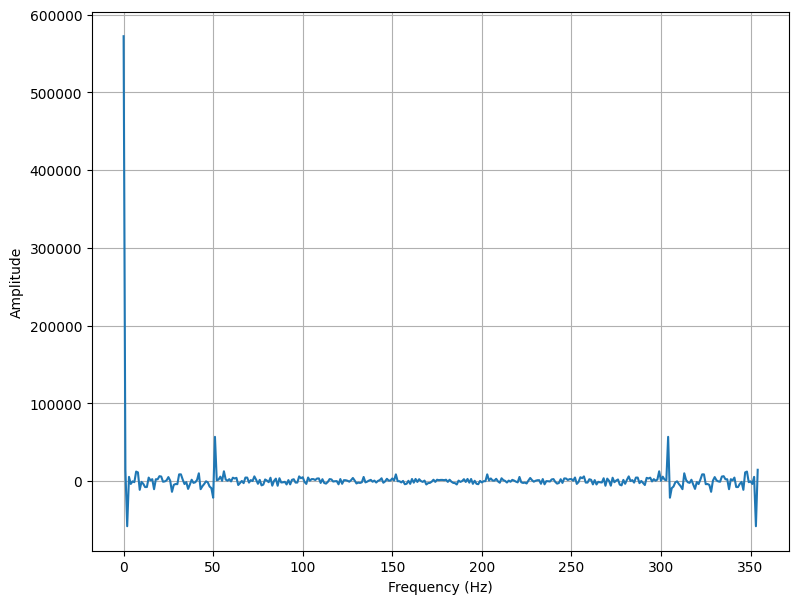

In [ ]:
from scipy import fftpack

y_fft = fftpack.fft(np.array(train))
plt.figure(figsize = (9, 7))
plt.grid()
plt.plot(y_fft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')


#inv = fftpack.ifft(y_fft)
#plt.plot(inv)

> There's 1 dominant frequency in the signal.

> To understand how FT can help detect seasonality in time-series, please refer to this srticle:
https://towardsai.net/p/machine-learning/seasonality-detection-with-fast-fourier-transform-fft-and-python

# Simple (equally-weighted) Moving Average (SMA) Forecasts


> **Forecasts using equation**

Before: 355
After: 386


<ipython-input-16-3f1ef0b24973>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hist = [train[i] for i in range(len(train))]


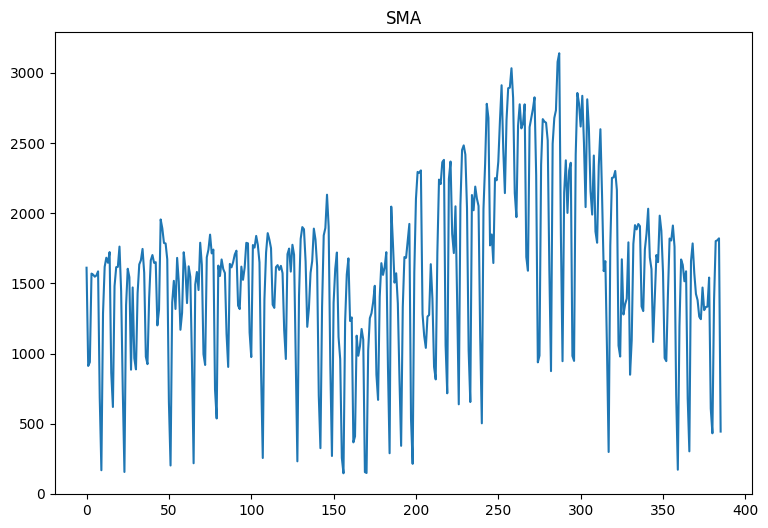

In [ ]:
#rolling window = 7days
window_size = 7
hist = [train[i] for i in range(len(train))]
print('Before:', len(hist))

pred0 = []
for t in range(len(test)):
    yhat = np.mean(hist[-(window_size)])
    obs = test.iloc[t]
    pred0.append(yhat)
    hist.append(obs)

print('After:', len(hist))

plt.figure(figsize = (9, 6))
plt.title('SMA')
plt.plot(hist)

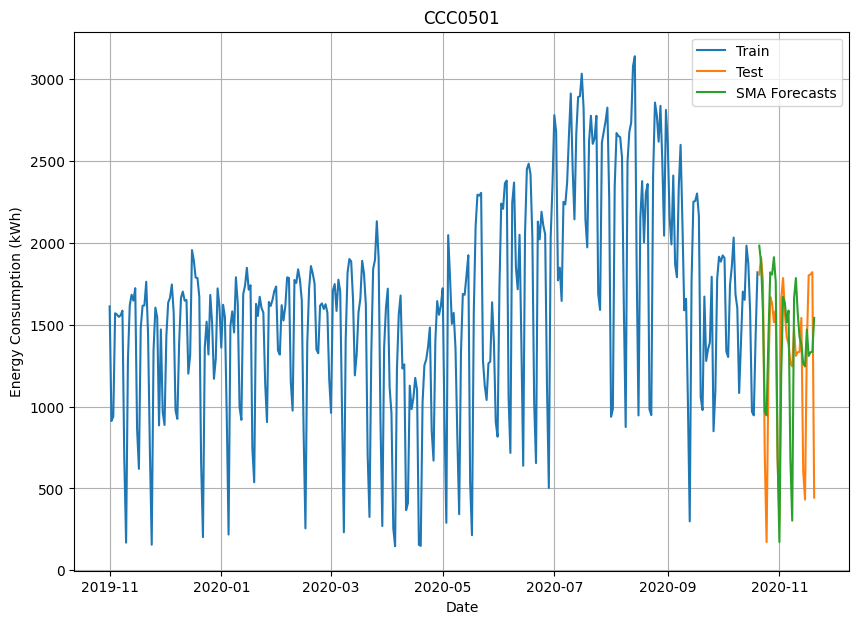

In [ ]:
def model_output(predicted_data):
    """Function: Plots test and predicted data for a visual comparison"""

    forecast_data = pd.DataFrame(predicted_data, index = test.index, columns = ['SMA Forecasts'])
    output = pd.concat([test, forecast_data], axis = 1)
    return output

out0 = model_output(pred0)
out0.rename(columns = {"Energy Consumption (kWh)": "Test"}, inplace = True)

plt.figure(figsize = (10, 7))
plt.title(site)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.plot(train, label = 'Train')
plt.plot(out0, label = out0.columns)
plt.legend(loc = 'upper right')

In [ ]:
def check_error(true, fore):
    """Function: Generates model performance metrics"""

    mse = mean_squared_error(true, fore)
    rmse = round(sqrt(mse), 2)
    #mape = round(np.mean(np.abs((true - fore) / true)) * 100, 2)
    #mean absolute percentage error
    #metrics = [rmse, mape]
    return rmse

check_error(test, pred0)

436.74

> **When you'd like to see the moving average over the training period of model**

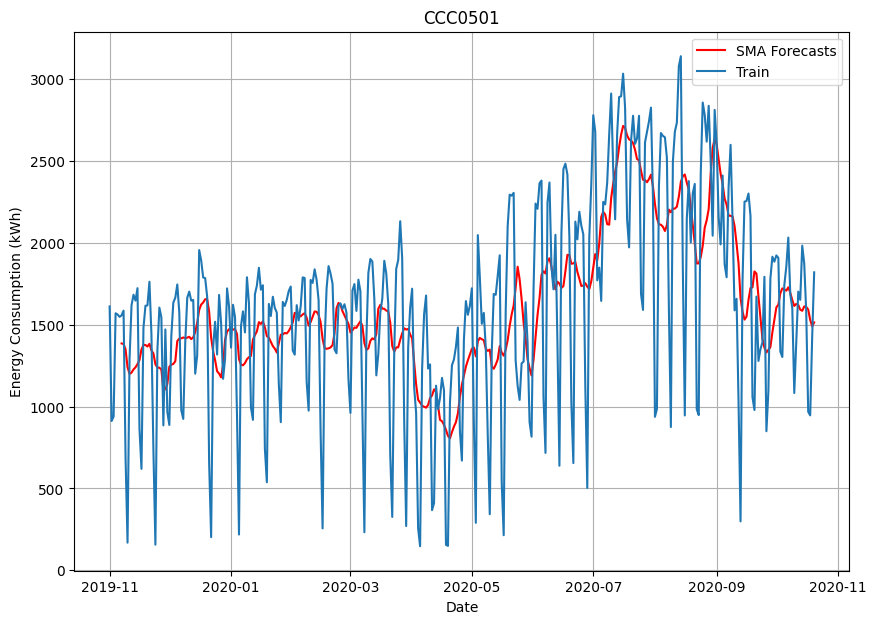

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(train.rolling(window = window_size).mean(), label = 'SMA Forecasts', color = 'red')
#plt.plot(train.rolling(window = window_size).mean().std(), label = 'STD', color = 'red')

plt.plot(train, label = 'Train')
plt.grid()
plt.title(site)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()

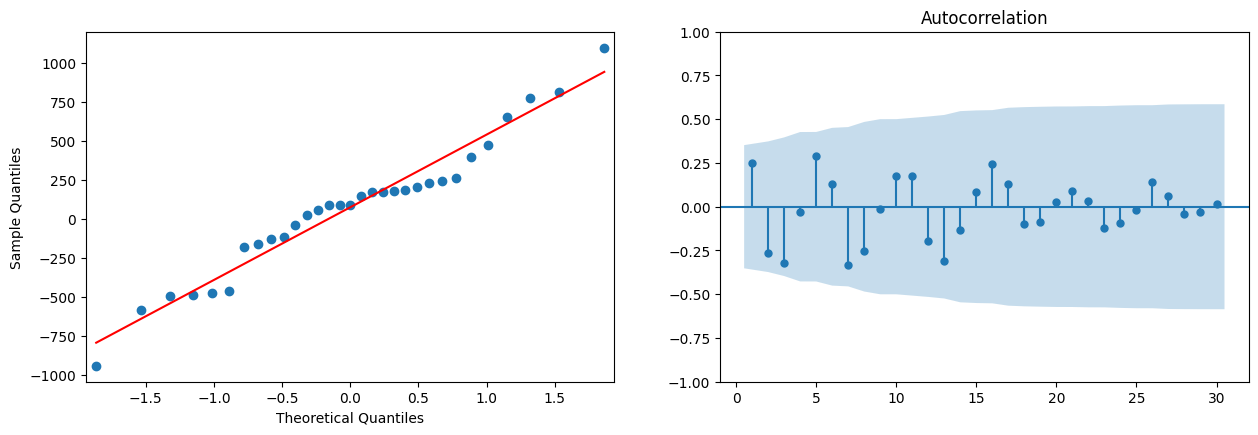

In [ ]:
def plot_error(output_data):
    """Function: Generates residual graphs"""

    plt.figure(figsize = (15, 10))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))

    ## QQ-plot of the residual
    sm.graphics.qqplot(output_data.iloc[:, 2], line = 'r', ax = ax1)

    # Autocorrelation plot of the residual
    plot_acf(output_data.iloc[:, 2], lags = len(output_data.iloc[:, 2])-1, zero = False, ax = ax2)

    return plt.show()

out0['Error'] = out0['SMA Forecasts'] - out0['Test']
rmse0 = check_error(test, pred0)
plot_error(out0)

In [ ]:
#errordf = pd.DataFrame(columns = ['Site ID', 'Forecast Model', 'RMSE'])
m0 = out0.columns[1][0:3]
errordf = pd.DataFrame({'Site ID': site, 'Forecast Model': m0,'RMSE': rmse0}, index = [0])
errordf

,Site ID,Forecast Model,RMSE
0,CCC0501,SMA,436.74


# Exponentially-weighted Moving Average (EMA) Forecasts

> **EMA over the training period of model using 2 smoothing parameters, just as an example.**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


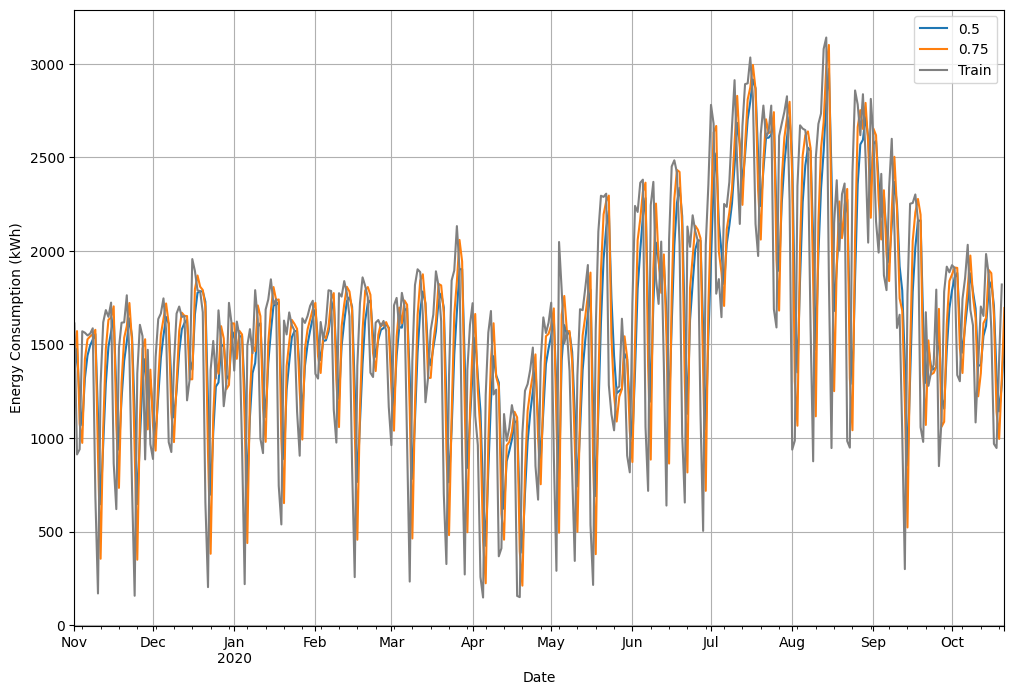

In [ ]:
#Average data period is 1/α. Ex. α = 1.0 -> lag = 1 period;
#α = 0.25 = 1/4 => lag = 4 periods

alpha = [0.5, 0.75]                 #smoothing parameter
for key, value in enumerate(alpha):
    model = ES(train).fit(smoothing_level = value)
    results = model.predict(start = 0, end = len(train))
    results.plot(figsize = (12, 8), title = '', label = value)

train.plot(figsize = (12, 8), color = 'Gray', label = 'Train')    #style = '--'
plt.ylabel('Energy Consumption (kWh)')
plt.grid()
plt.legend()
plt.show()

> Forecasts using the equation

Before: 355
After: 386


<ipython-input-29-2dac498032f3>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hist = [train[i] for i in range(len(train))]


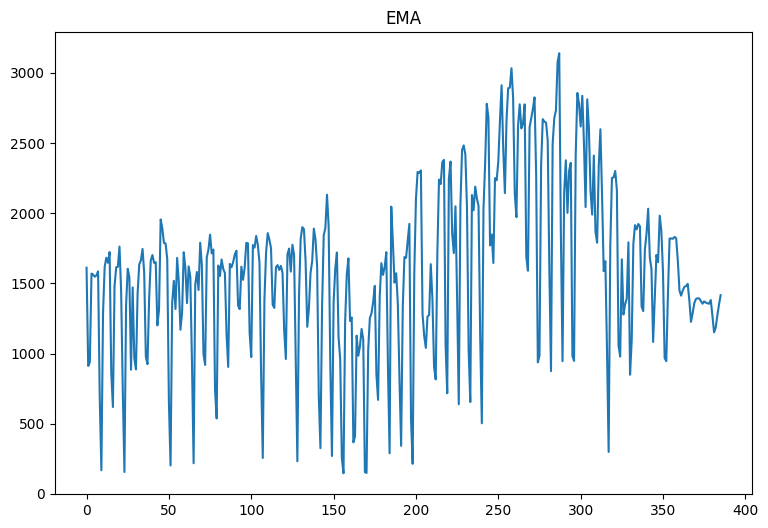

In [ ]:
alpha = 1.0/7.0
hist = [train[i] for i in range(len(train))]
hist_pred = [train.iloc[i] for i in range(len(train))]
print('Before:', len(hist_pred))

pred1 = []
for t in range(len(test)):
    yhat = hist_pred[-1] + alpha*(hist[-1] - hist_pred[-1])
    obs = test.iloc[t]
    pred1.append(yhat)
    hist.append(obs)
    hist_pred.append(yhat)

print('After:', len(hist_pred))

plt.figure(figsize = (9, 6))
plt.title('EMA')
plt.plot(hist_pred)

> **Forecasting model (ES) training**

In [ ]:
alpha = 0.15
model = ES(train).fit(smoothing_level = alpha)
print(model.summary())

                         ExponentialSmoothing Model Results                         
Dep. Variable:     Energy Consumption (kWh)   No. Observations:                  355
Model:                 ExponentialSmoothing   SSE                       99047208.363
Optimized:                             True   AIC                           4455.341
Trend:                                 None   BIC                           4463.085
Seasonal:                              None   AICC                          4455.456
Seasonal Periods:                      None   Date:                 Sun, 26 Jan 2025
Box-Cox:                              False   Time:                         13:02:00
Box-Cox Coeff.:                        None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1500000                alpha                Fals

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


> Forecasts using the model object from the library

In [ ]:
preds = model.predict(start = len(train)+1, end = len(train)+len(test))

In [ ]:
def check_error(true, fore):
    """This function generates performance metrics"""

    mse = mean_squared_error(true, fore)
    rmse = round(sqrt(mse), 2)
    #mape = round(np.mean(np.abs((true - fore) / true)) * 100, 2)
    #metrics = [rmse, mape]
    return rmse

check_error(test, preds)

535.93

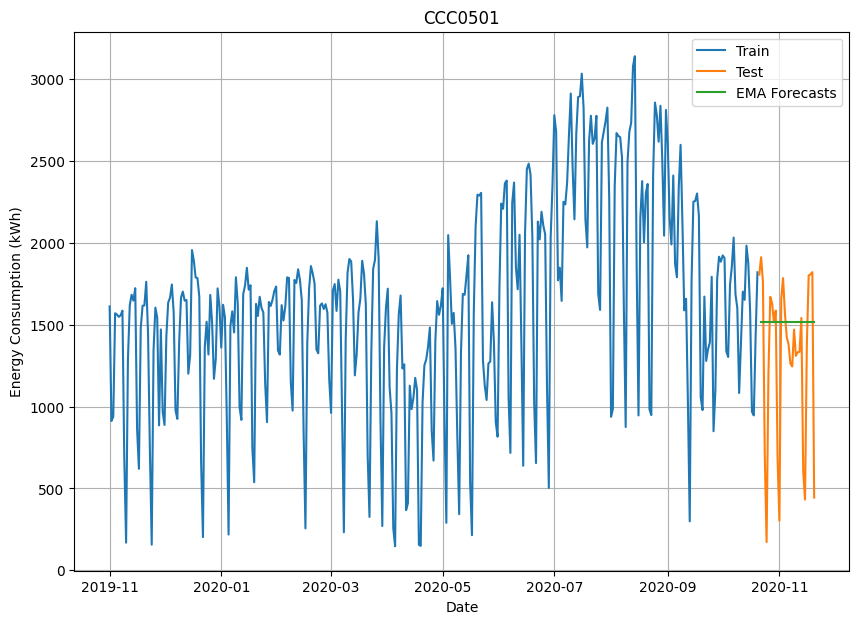

In [ ]:
def model_output(predicted_data):
    """Function: Plots test and predicted datasets for a visual comparison"""

    forecast_data = pd.DataFrame(predicted_data, index = test.index, columns = ['EMA Forecasts'])
    output = pd.concat([test, forecast_data], axis = 1)
    return output


out1 = model_output(preds)
out1.rename(columns = {"Energy Consumption (kWh)": "Test"}, inplace = True)

plt.figure(figsize = (10, 7))
plt.title(site)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.plot(train, label = 'Train')
plt.plot(out1, label = out1.columns)
plt.legend(loc = 'upper right')


> **A closer look on the forecasts**

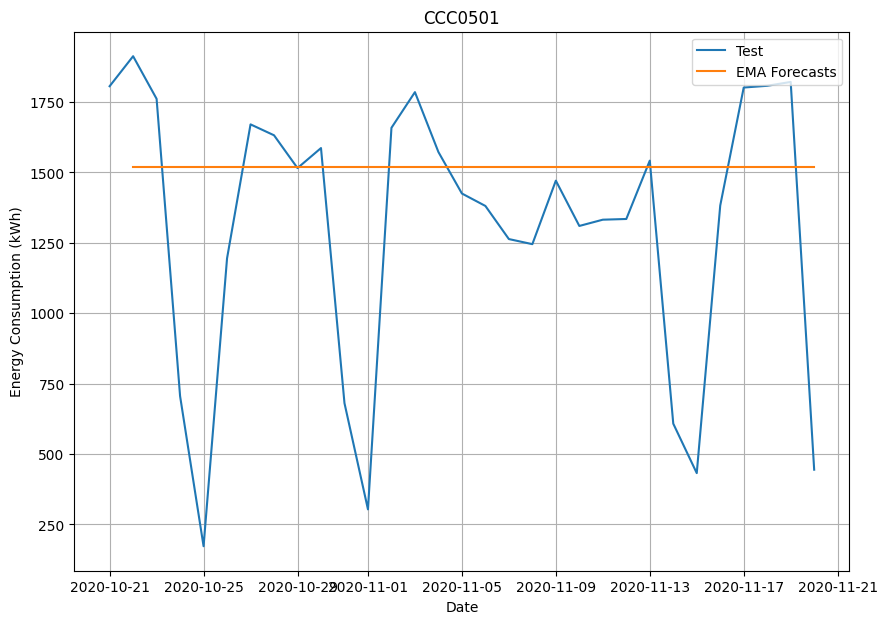

In [ ]:
plt.figure(figsize = (10, 7))
plt.title(site)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.plot(out1, label = out1.columns)
plt.legend(loc = 'upper right')

In [ ]:
def plot_error(output_data):
    """Function: Gnerates residual graphs"""

    plt.figure(figsize = (15, 10))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))

    ## QQ-plot of the residual
    sm.graphics.qqplot(output_data.iloc[:, 2], line = 'r', ax = ax1)

    # Autocorrelation plot of the residual
    plot_acf(output_data.iloc[:, 2], lags = len(output_data.iloc[:, 2])-1, zero = False, ax = ax2)

    return plt.show()

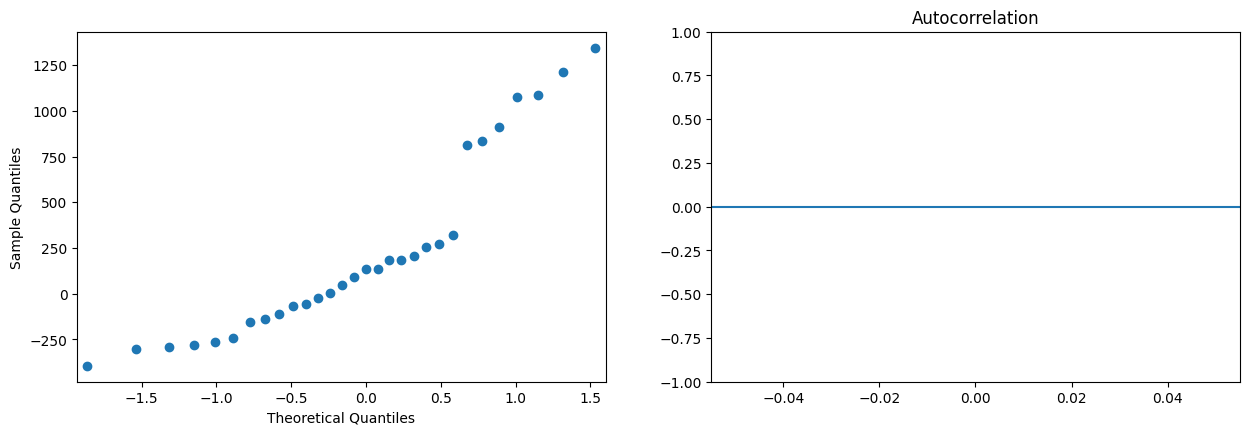

In [ ]:
out1['Error'] = out1['EMA Forecasts'] - out1['Test']
rmse1 = check_error(test, preds)
plot_error(out1)

**COMPARISON OF BASELINE MODELS**

In [ ]:
m1 = out1.columns[1][0:3]
errordf1 = pd.DataFrame({'Site ID': site, 'Forecast Model': m1,'RMSE': rmse1}, index = [1])
errordf1

,Site ID,Forecast Model,RMSE
1,CCC0501,EMA,535.93


In [ ]:
comp_df = pd.concat([errordf, errordf1], axis = 0)
comp_df

,Site ID,Forecast Model,RMSE
0,CCC0501,SMA,436.74
1,CCC0501,EMA,535.93


In [ ]:
#def model_output(predicted_data0, predicted_data1):
#    """Function: Plots test & predicted data for a visual comparison of the models"""

#    forecast_data0 = pd.DataFrame(predicted_data0, index = test.index, columns = ['SMA Forecasts'])
#    forecast_data1 = pd.DataFrame(predicted_data1, index = test.index, columns = ['EMA Forecasts'])


#    #avg_consumption = pd.DataFrame(test.describe()[1], index = test.index, columns = ["Average Energy Consumption (kWh)"])
#    siteid = pd.DataFrame(site, index = test.index, columns = ["Site ID"])
#    output = pd.concat([siteid, test, forecast_data0, forecast_data1], axis = 1)

#    return output.plot(title = site, figsize = (10, 7)), output

#plot, resultsdf = model_output(pred0, preds)


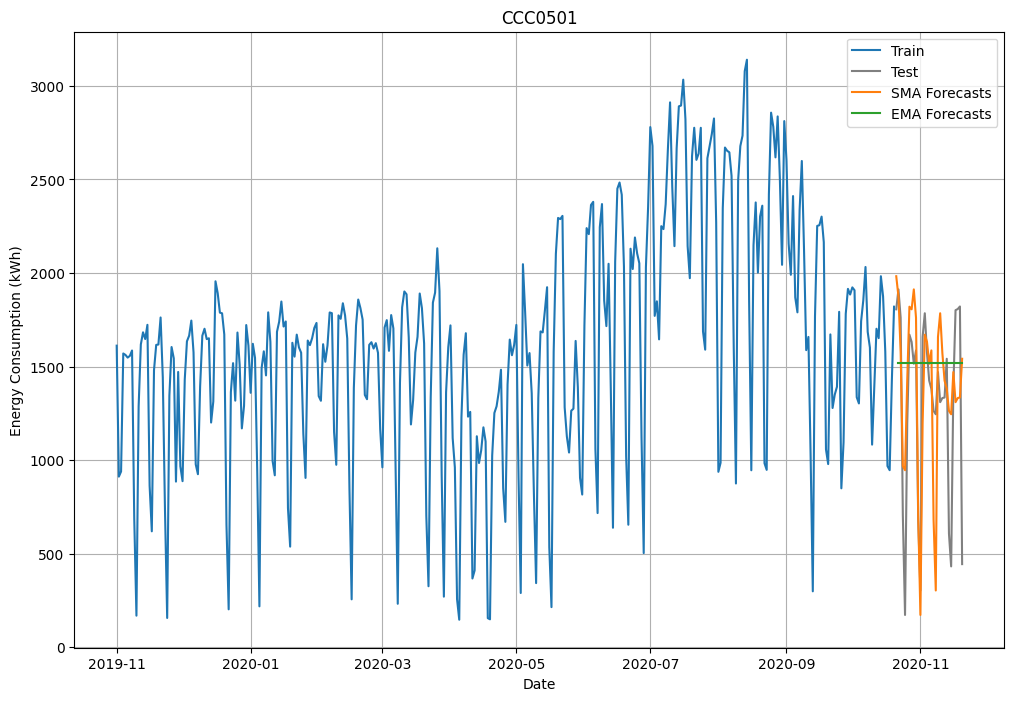

In [ ]:
plt.figure(figsize = (12, 8))
plt.title(site)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.plot(train, label = 'Train')
plt.plot(test, color = 'Gray', label = 'Test')
plt.plot(out0['SMA Forecasts'], label = 'SMA Forecasts')
plt.plot(out1['EMA Forecasts'], label = 'EMA Forecasts')
plt.legend(loc = 'upper right')

> **A simple moving average for this dataset works better and captures the data level well.**